In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
import numpy as np

torch.set_default_device("cuda")

seed = 404
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
generator = torch.Generator("cuda").manual_seed(seed)

# 1. MNIST 데이터셋 다운로드 및 전처리
transform = transforms.ToTensor()
mnist_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_size = int(0.8 * len(mnist_dataset))
val_size = len(mnist_dataset) - train_size
train_dataset, val_dataset = random_split(mnist_dataset, [train_size, val_size], generator)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, generator=generator)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, generator=generator)

In [2]:
# 2. VAE 모델 정의
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(64, 3)
        self.fc_logvar = nn.Linear(64, 3)
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()
        )
    
    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# VAE 모델 인스턴스화 및 손실 함수, 옵티마이저 정의
model = VAE()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [3]:
# 3. 일정 epoch 동안 모델 학습
num_epochs = 20
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for data, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        data = data.view(-1, 28*28).cuda()
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for data, _ in val_loader:
            data = data.view(-1, 28*28).cuda()
            recon_batch, mu, logvar = model(data)
            loss = loss_function(recon_batch, data, mu, logvar)
            val_loss += loss.item()
    
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

Epoch 1/20: 100%|██████████| 750/750 [00:07<00:00, 103.16it/s]


Epoch [1/20], Train Loss: 197.3000, Val Loss: 167.7474


Epoch 2/20: 100%|██████████| 750/750 [00:07<00:00, 105.71it/s]


Epoch [2/20], Train Loss: 160.2294, Val Loss: 155.8542


Epoch 3/20: 100%|██████████| 750/750 [00:07<00:00, 104.28it/s]


Epoch [3/20], Train Loss: 153.1502, Val Loss: 151.2825


Epoch 4/20: 100%|██████████| 750/750 [00:07<00:00, 104.51it/s]


Epoch [4/20], Train Loss: 149.6154, Val Loss: 148.1716


Epoch 5/20: 100%|██████████| 750/750 [00:07<00:00, 106.67it/s]


Epoch [5/20], Train Loss: 147.1203, Val Loss: 145.9871


Epoch 6/20: 100%|██████████| 750/750 [00:07<00:00, 106.53it/s]


Epoch [6/20], Train Loss: 144.8962, Val Loss: 143.9696


Epoch 7/20: 100%|██████████| 750/750 [00:07<00:00, 106.33it/s]


Epoch [7/20], Train Loss: 143.1433, Val Loss: 142.4710


Epoch 8/20: 100%|██████████| 750/750 [00:07<00:00, 106.69it/s]


Epoch [8/20], Train Loss: 141.8169, Val Loss: 141.3394


Epoch 9/20: 100%|██████████| 750/750 [00:06<00:00, 110.56it/s]


Epoch [9/20], Train Loss: 140.7090, Val Loss: 140.5259


Epoch 10/20: 100%|██████████| 750/750 [00:06<00:00, 110.86it/s]


Epoch [10/20], Train Loss: 139.8558, Val Loss: 139.5062


Epoch 11/20: 100%|██████████| 750/750 [00:06<00:00, 110.69it/s]


Epoch [11/20], Train Loss: 138.9729, Val Loss: 138.7665


Epoch 12/20: 100%|██████████| 750/750 [00:06<00:00, 109.57it/s]


Epoch [12/20], Train Loss: 138.3052, Val Loss: 138.4651


Epoch 13/20: 100%|██████████| 750/750 [00:06<00:00, 109.59it/s]


Epoch [13/20], Train Loss: 137.7056, Val Loss: 137.9356


Epoch 14/20: 100%|██████████| 750/750 [00:06<00:00, 107.34it/s]


Epoch [14/20], Train Loss: 137.2023, Val Loss: 137.3199


Epoch 15/20: 100%|██████████| 750/750 [00:07<00:00, 104.68it/s]


Epoch [15/20], Train Loss: 136.6040, Val Loss: 136.9306


Epoch 16/20: 100%|██████████| 750/750 [00:07<00:00, 105.81it/s]


Epoch [16/20], Train Loss: 136.1315, Val Loss: 136.4437


Epoch 17/20: 100%|██████████| 750/750 [00:07<00:00, 106.17it/s]


Epoch [17/20], Train Loss: 135.6030, Val Loss: 136.1246


Epoch 18/20: 100%|██████████| 750/750 [00:07<00:00, 106.27it/s]


Epoch [18/20], Train Loss: 135.1553, Val Loss: 135.9929


Epoch 19/20: 100%|██████████| 750/750 [00:06<00:00, 107.40it/s]


Epoch [19/20], Train Loss: 134.8563, Val Loss: 135.5735


Epoch 20/20: 100%|██████████| 750/750 [00:06<00:00, 107.29it/s]


Epoch [20/20], Train Loss: 134.4796, Val Loss: 135.0828


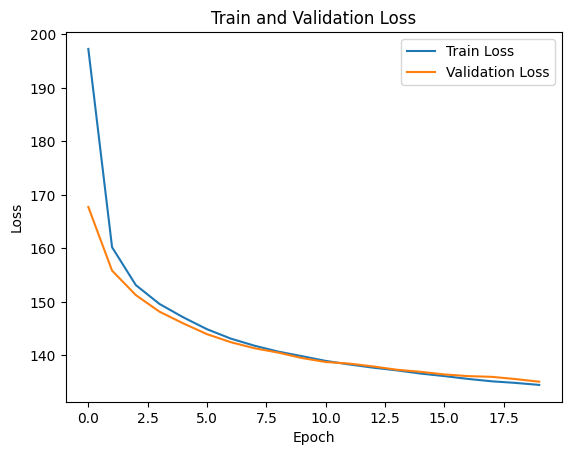

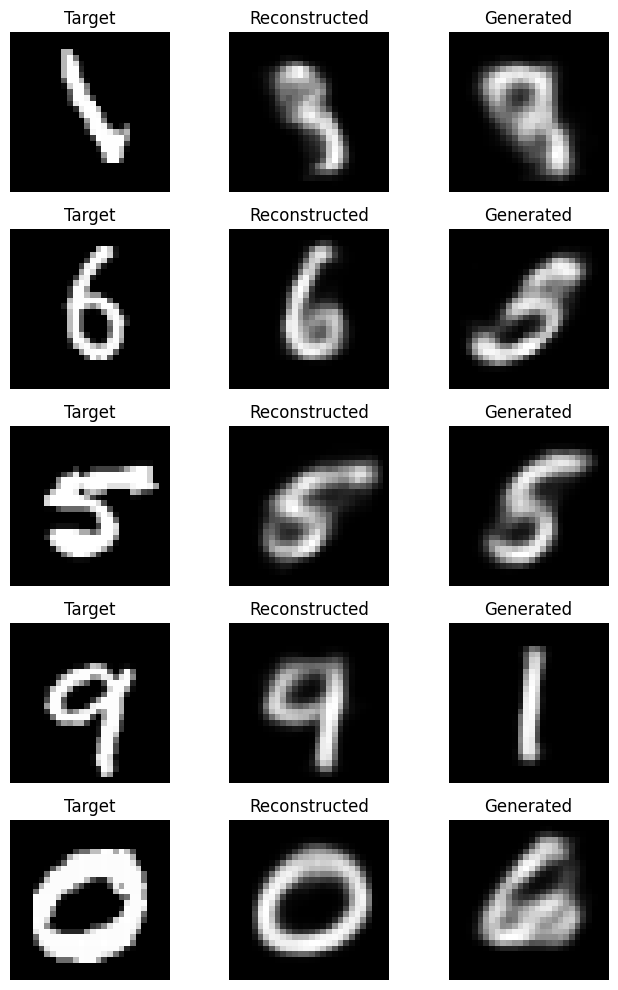

In [26]:
# 4. 학습 종료 후 에러 그래프 시각화
plt.figure()
plt.plot(range(num_epochs), train_losses, label='Train Loss')
plt.plot(range(num_epochs), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Validation Loss')
plt.show()

# 5. Validation set에서 5개의 데이터를 추출하여 오토인코딩 결과 시각화
model.eval()
with torch.no_grad():
    data_iter = iter(val_loader)
    data, _ = next(data_iter)
    data = data.view(-1, 28*28).cuda()
    recon_batch, mu, logvar = model(data)
    
    fig, axes = plt.subplots(5, 3, figsize=(7, 10))
    for i in range(5):
        axes[i, 0].imshow(data[i].view(28, 28).cpu().numpy(), cmap='gray')
        axes[i, 0].set_title('Target')
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(recon_batch[i].view(28, 28).cpu().numpy(), cmap='gray')
        axes[i, 1].set_title('Reconstructed')
        axes[i, 1].axis('off')
    
    # Gaussian noise로 생성한 이미지 시각화
    z = torch.randn(5, 3)
    generated_batch = model.decode(z)
    for i in range(5):
        axes[i, 2].imshow(generated_batch[i].view(28, 28).cpu().numpy(), cmap='gray')
        axes[i, 2].set_title('Generated')
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()